# Gibbs sampling

This practical demonstration is based on the material covered by Prof. Saad Jbabdi [here](https://users.fmrib.ox.ac.uk/~saad/ONBI/bayes_practical.html#sampling)

## Problem Statement

Consider a model with parameter set: 

$$ \mathbf{\theta} = \{\theta_{1},...,\theta_{n}\} $$

that generate some data $\mathbf{y}$.

We wish to estimate the posterior distributions of each parameter in the vector, $\theta$. 
We can use Gibbs sampling is method of approximating the posterior for each $\theta$ by sampling from their respective conditional probabilities:

$$ p(\theta_{j} \mid \theta_{-j}^{t-1}, \mathbf{y}) $$

Where $\theta_{-j}^{t-1}$ is an enumeration of all parameters $\theta$ except $\theta_{j}$. 

## Example: Bivariate normal

As a first example, we will investigate a Gibbs sampler from a bivariate normal distribition: 

$$\binom{\theta_{1}}{\theta_{2}} \mid \mathbf{y} \sim \mathcal{N}(\binom{y_{1}}{y_{2}}, \left(\begin{array}{cc} 1 & \rho\\\rho & 1\end{array}\right)) $$

This can done analytically, however, this is of little interest right now. 

The conditional posteriors for each parameter can be given by: 


$$ \theta_{1} \mid \theta_{2}, \mathbf{y} \sim \mathcal{N}(y_{1} + \frac{\Sigma_{12}}{\Sigma_{22}}(\theta_{2} - y_{2}), \Sigma_{11} - \frac{\Sigma_{12}^2}{\Sigma_{22}}) $$


$$ \theta_{2} \mid \theta_{1}, \mathbf{y} \sim \mathcal{N}(y_{2} + \frac{\Sigma_{12}}{\Sigma_{11}}(\theta_{1} - y_{1}), \Sigma_{22} - \frac{\Sigma_{12}^{2}}{\Sigma_{11}}) $$

Which, given our covariance matrix, $\Sigma$, simplifies to:

$$ \theta_{1} \mid \theta{2}, \mathbf{y} \sim \mathcal{N}(y_{1} + \rho(\theta_{2} - y_{2}), 1 - \rho^{2}) $$
$$ \theta_{2} \mid \theta{1}, \mathbf{y} \sim \mathcal{N}(y_{2} + \rho(\theta_{1} - y_{1}), 1 - \rho^{2}) $$

Note that the conditional posteriors of the multivariate distributions can be approximated by a normal distribution.

For the derivation of these conditional posteriors, see here. (link to be added later). 


### Implementation

#### True Distribution

We will begin by setting some parameters for means and covariance entries and plotting a resulting multivariate normal using a numpy implementation. 
The aim of the Gibbs sampling procedure will be to produces samples that converge on these example true mean and covariance. 

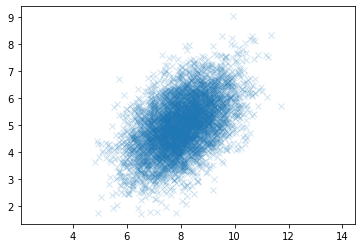

In [1]:
import numpy as np
import matplotlib.pyplot as plt


means = [8, 5]
cov = [[1, 0.5], [0.5, 1]] 

x, y = np.random.multivariate_normal(means, cov, 5000).T
plt.plot(x, y, 'x', alpha = 0.2)
plt.axis('equal')
plt.show()

#### Gibbs sampling
Now, we will define a function that will take in inputs of ... to and implement a Gibbs sampler.

In [2]:
def gibbs_sampler(theta, mean, cov, samples):
    ''' Function to implement a Gibbs sampler drawing from univariate normal
    approximations to conditional posterior distributions of parameters. 
    '''
    
    #Initialise vectors to store samples
    theta0 = np.empty([samples+1,1])
    theta1 = np.empty([samples+1,1])
    
    #Populate vectors with initial values
    theta0[0,0] = theta[0]
    theta1[0,0] = theta[1]
    
    # draw samples
    for i in range(samples):
        
        mean0 = mean[0] + (cov[0][1]*(theta1[i] - mean[1])) / cov[1][1]
        sigma0  = np.sqrt(cov[0][0] - cov[0][1]**2 / cov[1][1])
        theta0[i+1] = np.random.normal(mean0,sigma0,1)
        
        mean1 = mean[1] + (cov[1][0]*(theta0[i+1] - mean[0])) / cov[0][0]
        sigma1 = np.sqrt(cov[1][1] - cov[1][0]**2 / cov[0][0])
        theta1[i+1] = np.random.normal(mean1,sigma1,1)
        
    return theta0, theta1
        

In [3]:
guess = [0,0]
samples = 1000

theta0,theta1 = gibbs_sampler(theta=guess, mean = means, cov=cov, samples=samples)

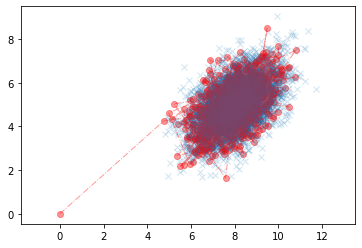

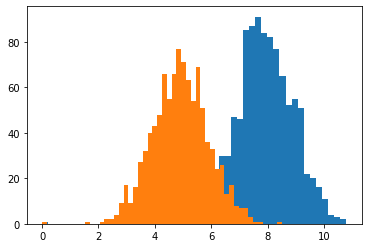

In [4]:
plt.plot(x, y, 'x', alpha = 0.2)
plt.plot(theta0,theta1, alpha=0.4, linestyle='-.', linewidth =1, color='r')
plt.scatter(theta0,theta1, color='r', alpha=0.4 )
plt.axis('equal')
plt.show()
plt.hist(theta0, bins=50)
plt.hist(theta1,bins=50)
plt.show()

## Example: Linear model

We can consider a similar process above for estimating unknown parameters from a linear model: 

$$ y = at + \epsilon$$ 

$$ \epsilon = \mathcal{N}(0, \sigma^{2}) $$ 
where, y is the data, x is a regressor, a is an unknown parameter and $\epsilon$ is noise assumed to be $\mathcal{N}(0, \sigma^{2})$, where $\sigma^{2}$ is the unknown variance. 

We wish to estimate the parameter unknown parameter $a$ that generates the data $y$, accounting for $x$ and $\epsilon$.
 
To complete the generative model, we place the following priors on $a$ and uniform priors on $\sigma^{2}$:

$$P(s^2)=1/s^{2}$$

$$P(a)=\mathcal{N}(0,\sigma_{0}^{2})$$

Gibbs sampling states that we can obtain the posterior for each unkown parameter by sampling from their respective conditional posteriors. 
We begin by generating some data.

### Generating True Data

We generate some datat that obeys the generative model above. 

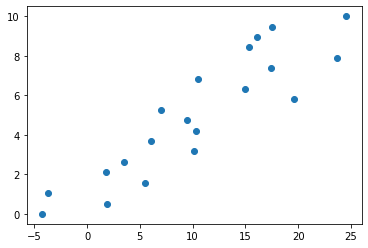

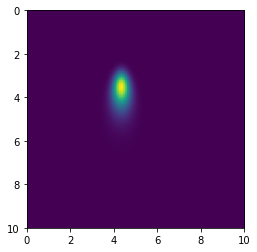

In [5]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
a   = 2; 
sigma = 5; 
t   = np.linspace(0,10,20)


y = a * t + np.random.normal(0,sigma,20)

# Plot synthetic data
plt.scatter(y,t)
plt.show()


va = np.linspace(0,5,100)
vs = np.linspace(.01,10,100)

posterior = np.zeros((len(vs),len(va)))

for i in range(100):
    for j in range(100):
        sample = va[j]*t                                        
        likelihood = (vs[i]**(-20))*np.exp(-np.sum((y-sample)**2)/2/vs[i]**2);     
        prior = 1/vs[i] * norm.pdf(va[j],0,1000);                
        posterior[i,j] = likelihood*prior;                             

        
posterior = posterior / np.sum(posterior)
plt.imshow(posterior, extent=[0,10,10,0])
plt.show()